In [2]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import random
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

In [3]:
df_mat = pd.read_csv("student-mat.csv")
df_por = pd.read_csv("student-por.csv")

df_mat.dropna(inplace=True)
df_por.dropna(inplace=True)

df_por["ID_p"] = list(range(1, len(df_por) + 1))
df_mat["ID_m"] = list(range(1, len(df_mat) + 1))

outer = df_mat.merge(df_por, how = "outer", on = ["school","sex","age","address","famsize","Pstatus","Medu","Fedu","Mjob","Fjob","reason","nursery","internet"], indicator=True)

# subset to students who only have math grades
math_only_temp = outer[(outer._merge== "left_only")].drop("_merge", axis=1)

# subset to students who only have portugese grades
por_only_temp = outer[(outer._merge == "right_only")].drop("_merge", axis = 1)

both_temp = outer[(outer._merge == "both")].drop("_merge", axis = 1)

random.seed(37)

# assign 0 or 1 to each student
both_temp["rand"] = [int(random.random() >.5) for i in range(0, len(both_temp))]

# if they are assigned 1, collect their math ID
rand_math_ID = list(both_temp[(both_temp["rand"] == 1)]["ID_m"])

# if assigned 0, collect their portugese ID
rand_por_ID = list(both_temp[(both_temp["rand"] == 0)]["ID_p"])

# create a new column to identify subject students grade is for
df_mat["Subject"] = "Math"
df_por["Subject"] = "Portugese"

# get ID's of those only enrolled in math
math_only_ID = list(math_only_temp["ID_m"])
# concat all the ID's of math students
all_math_ID = math_only_ID + rand_math_ID

# get ID's of those only enrolled in portugese
por_only_ID = list(por_only_temp["ID_p"])
# concat all the ID's of the portugese students
all_por_ID = por_only_ID + rand_por_ID

# get the dataframes with all the selected IDs
por_only_df = df_por[df_por["ID_p"].isin(all_por_ID)]
mat_only_df = df_mat[df_mat["ID_m"].isin(all_math_ID)]


In [4]:
# use assigned variables
# internet, paid, pstatus, absences -> Walc, Dalc
complete_df = pd.concat([por_only_df, mat_only_df])
updated_df = complete_df[['sex', 'age', 'Dalc', 'Walc', 'Pstatus', 'internet', 'paid', 'absences', 'G3']]

# combine workday and weekend alcohol consumption into an average overall weekly alcohol consumption (still on a scale of 1-5)
updated_df['Oalc'] = (updated_df['Dalc'] + updated_df['Walc']) / 2
updated_df

,sex,age,Dalc,Walc,Pstatus,internet,paid,absences,G3,Oalc
1,F,17,1,1,T,yes,no,2,11,1.0
7,F,17,1,1,A,no,no,2,13,1.0
9,M,15,1,1,T,yes,no,0,13,1.0
12,M,15,1,3,T,yes,no,0,12,2.0
13,M,15,1,2,T,yes,no,0,13,1.5
...,...,...,...,...,...,...,...,...,...,...
388,F,18,1,1,T,yes,yes,0,8,1.0
389,F,18,1,1,T,no,no,0,0,1.0
390,M,20,4,5,A,no,yes,11,9,4.5
392,M,21,3,3,T,no,no,3,7,3.0


In [5]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores
outcome, predictors = patsy.dmatrices('G3 ~ Oalc', data = updated_df)
model = sm.OLS(outcome, predictors)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.206
Date:                Sun, 10 Mar 2024   Prob (F-statistic):            0.00745
Time:                        05:08:52   Log-Likelihood:                -1855.5
No. Observations:                 676   AIC:                             3715.
Df Residuals:                     674   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9665      0.312     38.408      0.000      11.355      12.578
Oalc          -0.3925      0.146     -2.684      0.007      -0.680      -0.105
==============================================================================
Omnibus:                      117.374   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.957
Skew:                          -1.002   Prob(JB):                     8.59e-50
Kurtosis:                       5.002   Cond. No.                         5.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# get descriptive statistics of final grades of students who paid for extra courses
paid_courses = updated_df[updated_df['paid'] == 'yes']
paid_courses[["G3"]].describe()

,G3
count,120.000000
mean,10.933333
std,3.266158
min,0.000000
25%,9.000000
50%,11.000000
75%,13.000000
max,19.000000


In [7]:
# get descriptive statistics of final grades of students who did not pay for extra courses
no_paid_courses = updated_df[updated_df['paid'] == 'no']
no_paid_courses[["G3"]].describe()

,G3
count,556.000000
mean,11.289568
std,3.891404
min,0.000000
25%,10.000000
50%,11.000000
75%,14.000000
max,20.000000


Based on the descriptive statistics, only 120 students paid for extra courses compared to 556 who did not. Yet, the average final grade (G3) was lower for students who pay for extra courses (10.93) compared to students who didn't pay for extra courses (11.29). However, this difference in average scores is very small

<AxesSubplot:xlabel='G3', ylabel='paid'>

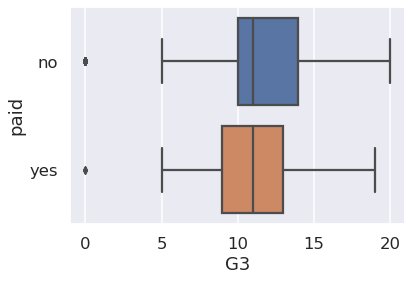

In [8]:
# boxplot showing the difference in 
sns.boxplot(data=updated_df, x="G3", y="paid")

In [22]:
# create OLS model to find a relationship on if a student pays or doesn't pay for extra classes compared with final grade scores in either math or Portugese
outcome_paid, predictors_paid = patsy.dmatrices('G3 ~ paid', data = updated_df)
model_paid = sm.OLS(outcome_paid, predictors_paid)
res_paid = model_paid.fit()
res_paid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.8727
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.351
Time:                        05:14:32   Log-Likelihood:                -1858.6
No. Observations:                 676   AIC:                             3721.
Df Residuals:                     674   BIC:                             3730.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      11.2896      0.161     70.266      0.000      10.974      11.605
paid[T.yes]    -0.3562      0.381     -0.934      0.351      -1.105       0.393
==============================================================================
Omnibus:                      109.221   Durbin-Watson:                   1.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              202.776
Skew:                          -0.954   Prob(JB):                     9.29e-45
Kurtosis:                       4.886   Cond. No.                         2.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

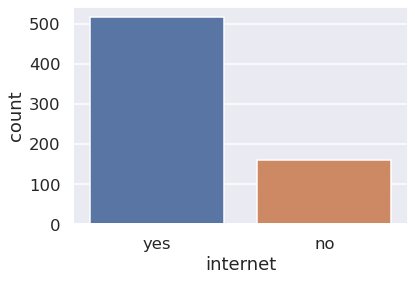

In [44]:
# plot of people who have access to internet vs people who don't have access to internet
plot_internet = sns.countplot(x='internet', data=updated_df)

In [47]:
# get descriptive statistics of final grades of students who had internet access
internet = updated_df[updated_df['internet'] == 'yes']
internet[["G3"]].describe()

,G3
count,516.000000
mean,11.494186
std,3.782685
min,0.000000
25%,10.000000
50%,11.000000
75%,14.000000
max,20.000000


In [48]:
# get descriptive statistics of final grades of students who do not have internet access
no_internet = updated_df[updated_df['internet'] == 'no']
no_internet[["G3"]].describe()

,G3
count,160.000000
mean,10.362500
std,3.686602
min,0.000000
25%,9.000000
50%,11.000000
75%,12.000000
max,19.000000


<AxesSubplot:xlabel='G3', ylabel='internet'>

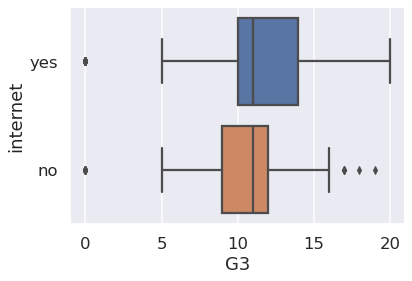

In [46]:
# boxplot of final grades for people with vs without access to internet
sns.boxplot(data=updated_df, x="G3", y="internet")

From the descriptive statistics and boxplot above we see that students with internet access average higher scores than students without internet access, but the difference between the means is very small

In [21]:
# create OLS model to find a relationship on access to internet compared with final grade scores in either math or Portugese
outcome_internet, predictors_internet = patsy.dmatrices('G3 ~ internet', data = updated_df)
model_internet = sm.OLS(outcome_internet, predictors_internet)
res_internet = model_internet.fit()
res_internet.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     11.06
Date:                Sun, 10 Mar 2024   Prob (F-statistic):           0.000929
Time:                        05:14:29   Log-Likelihood:                -1853.6
No. Observations:                 676   AIC:                             3711.
Df Residuals:                     674   BIC:                             3720.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.3625      0.297     34.859      0.000       9.779      10.946
internet[T.yes]     1.1317      0.340      3.326      0.001       0.464       1.800
==============================================================================
Omnibus:                      110.928   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              205.335
Skew:                          -0.969   Prob(JB):                     2.58e-45
Kurtosis:                       4.880   Cond. No.                         3.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

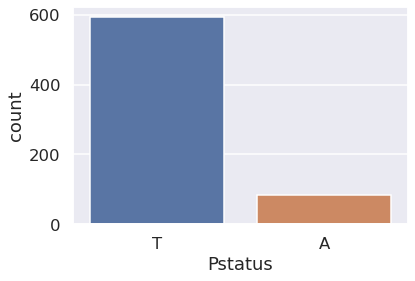

In [49]:
# plot of people who have access to internet vs people who don't have access to internet
plot_internet = sns.countplot(x='Pstatus', data=updated_df)

In [50]:
# get descriptive statistics of final grades of students whose parents are together
together = updated_df[updated_df['Pstatus'] == 'T']
together[["G3"]].describe()

,G3
count,593.000000
mean,11.197302
std,3.831748
min,0.000000
25%,10.000000
50%,11.000000
75%,14.000000
max,20.000000


In [51]:
# get descriptive statistics of final grades of students whose parents are together
apart = updated_df[updated_df['Pstatus'] == 'A']
apart[["G3"]].describe()

,G3
count,83.000000
mean,11.433735
std,3.475323
min,0.000000
25%,10.000000
50%,11.000000
75%,13.000000
max,19.000000


In [23]:
# OLS model to find a relationship on parent status (together or apart) compared with final grade scores in either math or Portugese
outcome_pstatus, predictors_pstatus = patsy.dmatrices('G3 ~ Pstatus', data = updated_df)
model_pstatus = sm.OLS(outcome_pstatus, predictors_pstatus)
res_pstatus = model.fit()
res_pstatus.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     7.206
Date:                Sun, 10 Mar 2024   Prob (F-statistic):            0.00745
Time:                        05:14:34   Log-Likelihood:                -1855.5
No. Observations:                 676   AIC:                             3715.
Df Residuals:                     674   BIC:                             3724.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.9665      0.312     38.408      0.000      11.355      12.578
Oalc          -0.3925      0.146     -2.684      0.007      -0.680      -0.105
==============================================================================
Omnibus:                      117.374   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              225.957
Skew:                          -1.002   Prob(JB):                     8.59e-50
Kurtosis:                       5.002   Cond. No.                         5.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:ylabel='Frequency'>

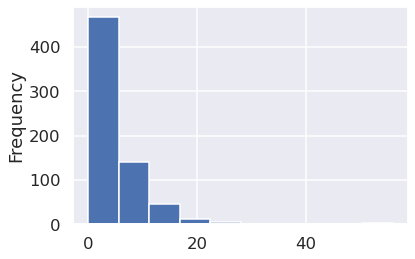

In [52]:
# plot histogram of student absences
# x axis is number of absences in bins incrementing by 5, and y axis is number of students who fall in the different range of absences
updated_df['absences'].plot(kind='hist')

In [20]:
# OLS model to find a relationship on absences compared with final grade scores in either math or Portugese
outcome_absences, predictors_absences = patsy.dmatrices('G3 ~ absences', data = updated_df)
model_absences = sm.OLS(outcome_absences, predictors_absences)
res_absences = model_absences.fit()
res_absences.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.851
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.174
Time:                        05:14:22   Log-Likelihood:                -1858.1
No. Observations:                 676   AIC:                             3720.
Df Residuals:                     674   BIC:                             3729.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.3719      0.181     62.932      0.000      11.017      11.727
absences      -0.0330      0.024     -1.361      0.174      -0.081       0.015
==============================================================================
Omnibus:                      117.271   Durbin-Watson:                   1.806
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              228.143
Skew:                          -0.996   Prob(JB):                     2.88e-50
Kurtosis:                       5.032   Cond. No.                         9.31
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores while considering that the students did or did not pay for extra classes
outcome_oalc_paid, predictors_oalc_paid = patsy.dmatrices('G3 ~ C(Oalc) + C(paid)', data = updated_df)
model_oalc_paid = sm.OLS(outcome_oalc_paid, predictors_oalc_paid)
res_oalc_paid = model_oalc_internet.fit()
res_oalc_paid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.653
Date:                Sun, 10 Mar 2024   Prob (F-statistic):            0.00501
Time:                        05:23:11   Log-Likelihood:                -1847.1
No. Observations:                 676   AIC:                             3714.
Df Residuals:                     666   BIC:                             3759.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.6723      0.342     31.235      0.000      10.001      11.343
C(Oalc)[T.1.5]         0.0250      0.416      0.060      0.952      -0.791       0.841
C(Oalc)[T.2.0]        -0.7224      0.440     -1.641      0.101      -1.587       0.142
C(Oalc)[T.2.5]        -0.2185      0.488     -0.448      0.654      -1.177       0.740
C(Oalc)[T.3.0]        -1.3774      0.566     -2.433      0.015      -2.489      -0.266
C(Oalc)[T.3.5]        -1.1345      0.704     -1.612      0.107      -2.516       0.247
C(Oalc)[T.4.0]        -0.1553      0.939     -0.165      0.869      -1.999       1.688
C(Oalc)[T.4.5]        -1.5182      1.436     -1.057      0.291      -4.337       1.301
C(Oalc)[T.5.0]        -1.7653      0.997     -1.771      0.077      -3.723       0.192
C(internet)[T.yes]     1.1843      0.340      3.480      0.001       0.516       1.852
==============================================================================
Omnibus:                      124.108   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.558
Skew:                          -1.044   Prob(JB):                     7.85e-54
Kurtosis:                       5.079   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores while considering access to internet
outcome_oalc_internet, predictors_oalc_internet = patsy.dmatrices('G3 ~ C(Oalc) + C(internet)', data = updated_df)
model_oalc_internet = sm.OLS(outcome_oalc_internet, predictors_oalc_internet)
res_oalc_internet = model_oalc_internet.fit()
res_oalc_internet.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.653
Date:                Sun, 10 Mar 2024   Prob (F-statistic):            0.00501
Time:                        05:23:04   Log-Likelihood:                -1847.1
No. Observations:                 676   AIC:                             3714.
Df Residuals:                     666   BIC:                             3759.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             10.6723      0.342     31.235      0.000      10.001      11.343
C(Oalc)[T.1.5]         0.0250      0.416      0.060      0.952      -0.791       0.841
C(Oalc)[T.2.0]        -0.7224      0.440     -1.641      0.101      -1.587       0.142
C(Oalc)[T.2.5]        -0.2185      0.488     -0.448      0.654      -1.177       0.740
C(Oalc)[T.3.0]        -1.3774      0.566     -2.433      0.015      -2.489      -0.266
C(Oalc)[T.3.5]        -1.1345      0.704     -1.612      0.107      -2.516       0.247
C(Oalc)[T.4.0]        -0.1553      0.939     -0.165      0.869      -1.999       1.688
C(Oalc)[T.4.5]        -1.5182      1.436     -1.057      0.291      -4.337       1.301
C(Oalc)[T.5.0]        -1.7653      0.997     -1.771      0.077      -3.723       0.192
C(internet)[T.yes]     1.1843      0.340      3.480      0.001       0.516       1.852
==============================================================================
Omnibus:                      124.108   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              244.558
Skew:                          -1.044   Prob(JB):                     7.85e-54
Kurtosis:                       5.079   Cond. No.                         13.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores while considering each student's parent status (together or apart)
outcome_oalc_pstatus, predictors_oalc_pstatus = patsy.dmatrices('G3 ~ C(Oalc) + Pstatus', data = updated_df)
model_oalc_pstatus = sm.OLS(outcome_oalc_pstatus, predictors_oalc_pstatus)
res_oalc_pstatus = model_oalc_pstatus.fit()
res_oalc_pstatus.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.294
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.236
Time:                        05:23:50   Log-Likelihood:                -1853.2
No. Observations:                 676   AIC:                             3726.
Df Residuals:                     666   BIC:                             3772.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.6442      0.447     26.026      0.000      10.766      12.523
C(Oalc)[T.1.5]     0.0947      0.419      0.226      0.821      -0.728       0.918
C(Oalc)[T.2.0]    -0.6223      0.445     -1.400      0.162      -1.495       0.251
C(Oalc)[T.2.5]    -0.1543      0.492     -0.314      0.754      -1.121       0.812
C(Oalc)[T.3.0]    -1.3303      0.573     -2.320      0.021      -2.456      -0.205
C(Oalc)[T.3.5]    -1.0385      0.710     -1.464      0.144      -2.432       0.355
C(Oalc)[T.4.0]    -0.1764      0.947     -0.186      0.852      -2.037       1.684
C(Oalc)[T.4.5]    -1.5326      1.449     -1.058      0.290      -4.377       1.312
C(Oalc)[T.5.0]    -1.5894      1.005     -1.581      0.114      -3.564       0.385
Pstatus[T.T]      -0.1301      0.446     -0.292      0.771      -1.006       0.746
==============================================================================
Omnibus:                      117.618   Durbin-Watson:                   1.813
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              226.192
Skew:                          -1.004   Prob(JB):                     7.64e-50
Kurtosis:                       4.999   Cond. No.                         13.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores while considering number of absences
outcome_oalc_absences, predictors_oalc_absences = patsy.dmatrices('G3 ~ C(Oalc) + absences', data = updated_df)
model_oalc_absences = sm.OLS(outcome_oalc_absences, predictors_oalc_absences)
res_oalc_absences = model_oalc_absences.fit()
res_oalc_absences.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     1.398
Date:                Sun, 10 Mar 2024   Prob (F-statistic):              0.185
Time:                        05:24:52   Log-Likelihood:                -1852.7
No. Observations:                 676   AIC:                             3725.
Df Residuals:                     666   BIC:                             3771.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         11.6228      0.254     45.818      0.000      11.125      12.121
C(Oalc)[T.1.5]     0.1091      0.419      0.260      0.795      -0.714       0.932
C(Oalc)[T.2.0]    -0.6271      0.443     -1.415      0.158      -1.497       0.243
C(Oalc)[T.2.5]    -0.1070      0.494     -0.216      0.829      -1.077       0.864
C(Oalc)[T.3.0]    -1.2908      0.573     -2.252      0.025      -2.416      -0.165
C(Oalc)[T.3.5]    -0.9868      0.710     -1.389      0.165      -2.382       0.408
C(Oalc)[T.4.0]    -0.1730      0.947     -0.183      0.855      -2.032       1.686
C(Oalc)[T.4.5]    -1.4156      1.452     -0.975      0.330      -4.267       1.436
C(Oalc)[T.5.0]    -1.5141      1.008     -1.503      0.133      -3.493       0.465
absences          -0.0246      0.025     -1.001      0.317      -0.073       0.024
==============================================================================
Omnibus:                      125.551   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              252.467
Skew:                          -1.046   Prob(JB):                     1.50e-55
Kurtosis:                       5.142   Cond. No.                         75.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
# OLS for finding if there is a relationship between overall weekly alcohol consumption and final class scores while considering absences, parent status, access to internet, and whether or not student paid for extra classes
outcome_all, predictors_all = patsy.dmatrices('G3 ~ C(Oalc) + C(paid) + C(internet) + Pstatus + absences', data = updated_df)
model_all = sm.OLS(outcome_all, predictors_all)
res_all = model_all.fit()
res_all.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     2.290
Date:                Sun, 10 Mar 2024   Prob (F-statistic):            0.00740
Time:                        05:26:32   Log-Likelihood:                -1845.3
No. Observations:                 676   AIC:                             3717.
Df Residuals:                     663   BIC:                             3775.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             11.0335      0.506     21.790      0.000      10.039      12.028
C(Oalc)[T.1.5]         0.0682      0.416      0.164      0.870      -0.749       0.885
C(Oalc)[T.2.0]        -0.6869      0.441     -1.557      0.120      -1.553       0.179
C(Oalc)[T.2.5]        -0.1468      0.490     -0.299      0.765      -1.110       0.816
C(Oalc)[T.3.0]        -1.2786      0.571     -2.239      0.026      -2.400      -0.157
C(Oalc)[T.3.5]        -1.0526      0.705     -1.492      0.136      -2.438       0.333
C(Oalc)[T.4.0]        -0.1257      0.939     -0.134      0.893      -1.969       1.717
C(Oalc)[T.4.5]        -1.3647      1.440     -0.948      0.344      -4.192       1.463
C(Oalc)[T.5.0]        -1.6226      1.001     -1.621      0.105      -3.587       0.342
C(paid)[T.yes]        -0.4258      0.382     -1.116      0.265      -1.175       0.324
C(internet)[T.yes]     1.2830      0.344      3.726      0.000       0.607       1.959
Pstatus[T.T]          -0.2909      0.447     -0.651      0.515      -1.169       0.587
absences              -0.0326      0.025     -1.321      0.187      -0.081       0.016
==============================================================================
Omnibus:                      137.365   Durbin-Watson:                   1.855
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.709
Skew:                          -1.113   Prob(JB):                     4.53e-64
Kurtosis:                       5.325   Cond. No.                         75.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""